Используя датасет с Входящими в автобус и Выходящими из него людьми, создать бинарный классификатор по определению следующих классов:
- входящий пассажир
- выходящий пассажир
Ссылка на датасет: https://storage.googleapis.com/terra_ai/DataSets/bus.zip

In [1]:
import gdown
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from zipfile import ZipFile

from keras.models import Sequential

from tensorflow.keras.preprocessing import image
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam

# Подготовка

## Загрузка датасета

In [10]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip',None,quiet=True)

'bus.zip'

In [12]:
with ZipFile('bus.zip', 'r') as zipObj:
    zipObj.extractall(path = 'C:/Users/Aleshka5/my_projects/content/data_bus')

In [2]:
# Опытным путём был выявлен средний размер фотографий в датасете
shape_0 = 342
shape_1 = 207
print(f"mean photo shape: {shape_0}x{shape_1}")

mean photo shape: 342x207


## Нужные функции

In [2]:
def preprocess():
    root_folder_path = "content/data_bus/"
    classes = os.listdir(root_folder_path)  
    # Проверка папок директории датасета
    print(f"Всего {len(classes)} класса: {classes}")
    
    shape_0 = 342//2
    shape_1 = 207//2
    X = []
    Y = []      
    i = 0
    # Запишем все фотографии в нужном разрешении в npumpy массивы
    for cls in classes:      
        for img_path in os.listdir(f"{root_folder_path}/{cls}/"):            
            X.append(np.array(image.load_img(f"{root_folder_path}/{cls}/{img_path}",target_size=(shape_0,shape_1))))
            Y.append(i)  
        i+=1
    
    X = np.array(X)
    Y = np.array(Y)
    print(f"Размерность датасета картинок: {X.shape}")
    print(f"Размерность датасета меток:    {Y.shape}\n")
    
    i+=1   
    # Разобьём Датасет на 90% - тренировочных + валидационных данных | 10% - тестовых данных
    X, x_test, Y, y_test = train_test_split(X,Y,test_size = 0.1,
                                                            shuffle=True,
                                                            random_state=6)
    # Разобьём (тренировочные + проверочные) данные на 90% - тренировочных данных | 10% - проверочных данных
    x_train, x_val, y_train, y_val = train_test_split(X,Y,test_size = 0.1,
                                                            shuffle=True,
                                                            random_state=6)  
    del(X)
    del(Y)
    x_train = np.array(x_train,dtype = 'float32')
    x_val   = np.array(x_val,dtype = 'float32')
    x_test  = np.array(x_test,dtype = 'float32')

    y_train = np.array(y_train)
    y_val   = np.array(y_val)
    y_test  = np.array(y_test)

    return x_train / 255, x_val / 255, x_test / 255, y_train, y_val, y_test
def evol(history):
    plt.plot(history.history['accuracy'],label='acc')
    plt.plot(history.history['val_accuracy'],label='val_acc')
    plt.legend()
    plt.title("Accuracy")
    plt.show()
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.legend()
    plt.title("Loss")
    plt.show()

In [3]:
x_train, x_val, x_test, y_train, y_val, y_test = preprocess()

Всего 2 класса: ['Входящий', 'Выходящий']
Размерность датасета картинок: (9081, 171, 103, 3)
Размерность датасета меток:    (9081,)



## Записать датасет в файл

In [7]:
with open('dataset_bus.pickle', 'wb') as f:
    pickle.dump((x_train, x_val, x_test, y_train, y_val, y_test), f)

## Загрузить датасет из файла

In [2]:
with open('dataset_bus.pickle', 'rb') as f:
    x_train, x_val, x_test, y_train, y_val, y_test = pickle.load(f)

## Вывести размер датасета

In [4]:
print(f"Размерность тренировочного набора картинок (x_train): {x_train.shape}")
print(f"Размерность тренировочного набора меток    (y_train): {y_train.shape}\n")

print(f"Размерность проверочного набора картинок   (x_val):   {x_val.shape}")
print(f"Размерность проверочного набора меток      (y_val):   {y_val.shape}\n")

print(f"Размерность тестового набора картинок      (x_test):  {x_test.shape}")
print(f"Размерность тестового  набора меток        (y_test):  {y_test.shape}")

Размерность тренировочного набора картинок (x_train): (7354, 171, 103, 3)
Размерность тренировочного набора меток    (y_train): (7354,)

Размерность проверочного набора картинок   (x_val):   (818, 171, 103, 3)
Размерность проверочного набора меток      (y_val):   (818,)

Размерность тестового набора картинок      (x_test):  (909, 171, 103, 3)
Размерность тестового  набора меток        (y_test):  (909,)


## Вывести примеры изображений

0


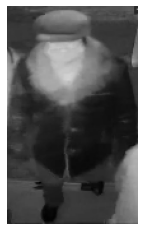

0


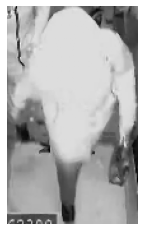

1


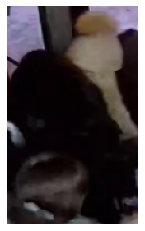

0


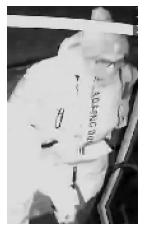

1


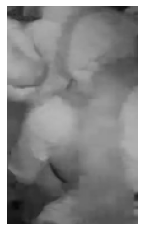

In [5]:
for n in range(1,x_val.shape[0],200):
    print(y_val[n])
    plt.axis(False)
    plt.imshow(x_val[n])
    plt.show()

# First Model Architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 171, 103, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 57, 34, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 34, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 3, 64)         0

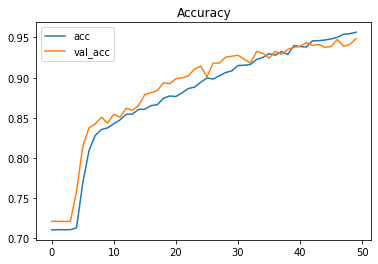

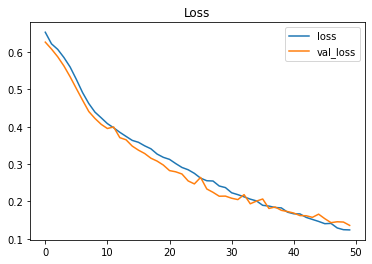

In [8]:
model = Sequential()
model.add(Conv2D(16,3,activation= 'relu',padding='same',input_shape=(x_train.shape[1:])))
model.add(MaxPooling2D(3))
model.add(Conv2D(32,3,activation= 'relu',padding='same',))
model.add(MaxPooling2D(3))
model.add(Conv2D(64,3,activation= 'relu',padding='same',))
model.add(MaxPooling2D(3))


model.add(Flatten())

model.add(Dense(32,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(8,activation='softmax'))
model.add(Dense(32,activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
model.summary()

history = model.fit(x_train,y_train,
                    validation_data = (x_val,y_val),
                    batch_size = 32,
                    epochs = 50,
                    verbose = 1)        
scores = model.evaluate(x_test,y_test,verbose = 1)
evol(history)

Epoch 1/30
115/115 [==============================] - 3s 22ms/step - loss: 0.1057 - accuracy: 0.9664 - val_loss: 0.1340 - val_accuracy: 0.9511
Epoch 2/30
115/115 [==============================] - 2s 18ms/step - loss: 0.1085 - accuracy: 0.9636 - val_loss: 0.1328 - val_accuracy: 0.9511
Epoch 3/30
115/115 [==============================] - 2s 18ms/step - loss: 0.1086 - accuracy: 0.9640 - val_loss: 0.1315 - val_accuracy: 0.9523
Epoch 4/30
115/115 [==============================] - 2s 18ms/step - loss: 0.1071 - accuracy: 0.9653 - val_loss: 0.1318 - val_accuracy: 0.9499
Epoch 5/30
115/115 [==============================] - 2s 17ms/step - loss: 0.1080 - accuracy: 0.9622 - val_loss: 0.1316 - val_accuracy: 0.9499
Epoch 6/30
115/115 [==============================] - 2s 17ms/step - loss: 0.1053 - accuracy: 0.9642 - val_loss: 0.1321 - val_accuracy: 0.9511
Epoch 7/30
115/115 [==============================] - 2s 18ms/step - loss: 0.1021 - accuracy: 0.9667 - val_loss: 0.1333 - val_accuracy: 0.9462

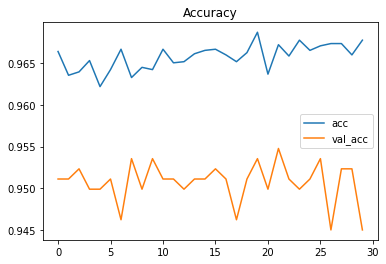

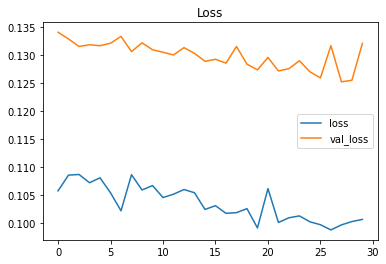

In [9]:
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.00001),metrics=['accuracy'])

history = model.fit(x_train,y_train,
                    validation_data = (x_val,y_val),
                    batch_size = 64,
                    epochs = 30,
                    verbose = 1)        
scores = model.evaluate(x_test,y_test,verbose = 1)
evol(history)

# Second Model Architecture

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 171, 103, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 57, 34, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 57, 34, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 19, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 19, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 3, 64)        

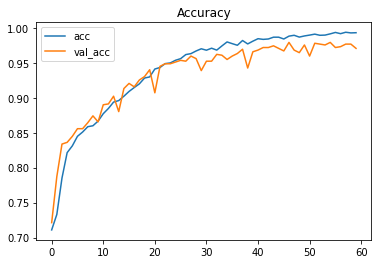

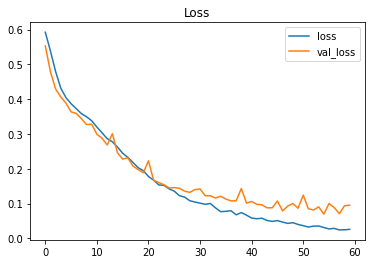

In [8]:
model = Sequential()
model.add(Conv2D(16,3,activation= 'relu',padding='same',input_shape=(x_train.shape[1:])))
model.add(MaxPooling2D(3))
model.add(Conv2D(32,3,activation= 'relu',padding='same',))
model.add(MaxPooling2D(3))
model.add(Conv2D(64,3,activation= 'relu',padding='same',))
model.add(MaxPooling2D(3))


model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16,activation='sigmoid'))
#model.add(Dense(8,activation='softmax'))
#model.add(Dense(32,activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
model.summary()

history = model.fit(x_train,y_train,
                    validation_data = (x_val,y_val),
                    batch_size = 32,
                    epochs = 60,
                    verbose = 1)        
scores = model.evaluate(x_test,y_test,verbose = 1)
evol(history)

Epoch 1/30
230/230 [==============================] - 3s 12ms/step - loss: 0.0184 - accuracy: 0.9958 - val_loss: 0.0813 - val_accuracy: 0.9768
Epoch 2/30
230/230 [==============================] - 3s 11ms/step - loss: 0.0176 - accuracy: 0.9967 - val_loss: 0.0814 - val_accuracy: 0.9768
Epoch 3/30
230/230 [==============================] - 3s 11ms/step - loss: 0.0162 - accuracy: 0.9971 - val_loss: 0.0817 - val_accuracy: 0.9756
Epoch 4/30
230/230 [==============================] - 3s 11ms/step - loss: 0.0166 - accuracy: 0.9965 - val_loss: 0.0802 - val_accuracy: 0.9780
Epoch 5/30
230/230 [==============================] - 3s 11ms/step - loss: 0.0149 - accuracy: 0.9967 - val_loss: 0.0851 - val_accuracy: 0.9780
Epoch 6/30
230/230 [==============================] - 3s 11ms/step - loss: 0.0156 - accuracy: 0.9971 - val_loss: 0.0835 - val_accuracy: 0.9780
Epoch 7/30
230/230 [==============================] - 3s 11ms/step - loss: 0.0153 - accuracy: 0.9966 - val_loss: 0.0804 - val_accuracy: 0.9780

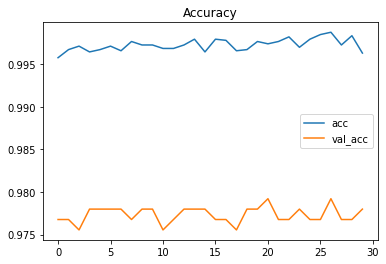

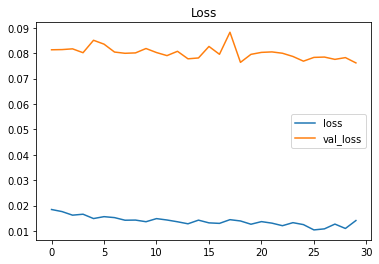

In [10]:
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.00001),metrics=['accuracy'])
history = model.fit(x_train,y_train,
                    validation_data = (x_val,y_val),
                    batch_size = 32,
                    epochs = 30,
                    verbose = 1)        
scores = model.evaluate(x_test,y_test,verbose = 1)
evol(history)

# Third Model Architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 171, 103, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 57, 34, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 57, 34, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 34, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 11, 32)       0         
 2D)                                                             
                                                        

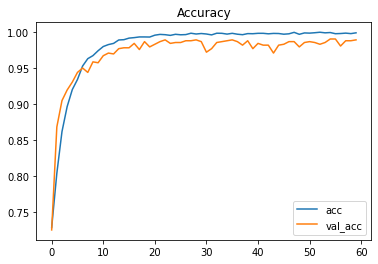

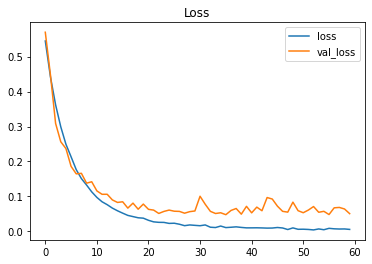

In [5]:
model = Sequential()

model.add(Conv2D(16,3,activation= 'relu',padding='same',input_shape=(x_train.shape[1:])))
model.add(MaxPooling2D(3))
model.add(BatchNormalization())

model.add(Conv2D(32,3,activation= 'relu',padding='same',))
model.add(MaxPooling2D(3))
model.add(BatchNormalization())

model.add(Conv2D(64,3,activation= 'relu',padding='same',))
model.add(MaxPooling2D(3))
model.add(BatchNormalization())


model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16,activation='sigmoid'))
#model.add(Dense(8,activation='softmax'))
#model.add(Dense(32,activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
model.summary()

history = model.fit(x_train,y_train,
                    validation_data = (x_val,y_val),
                    batch_size = 32,
                    epochs = 60,
                    verbose = 1)        
scores = model.evaluate(x_test,y_test,verbose = 1)
evol(history)

Epoch 1/20
115/115 [==============================] - 4s 23ms/step - loss: 0.0058 - accuracy: 0.9988 - val_loss: 0.0530 - val_accuracy: 0.9866
Epoch 2/20
115/115 [==============================] - 2s 18ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 0.0537 - val_accuracy: 0.9866
Epoch 3/20
115/115 [==============================] - 2s 18ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.0527 - val_accuracy: 0.9866
Epoch 4/20
115/115 [==============================] - 2s 18ms/step - loss: 0.0049 - accuracy: 0.9989 - val_loss: 0.0520 - val_accuracy: 0.9866
Epoch 5/20
115/115 [==============================] - 2s 18ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.0518 - val_accuracy: 0.9866
Epoch 6/20
115/115 [==============================] - 2s 18ms/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.0518 - val_accuracy: 0.9866
Epoch 7/20
115/115 [==============================] - 2s 18ms/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.0515 - val_accuracy: 0.9866

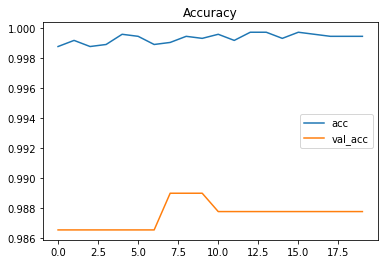

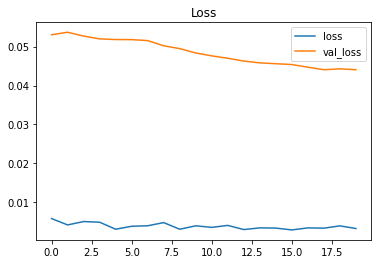

In [6]:
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.000001),metrics=['accuracy'])
history = model.fit(x_train,y_train,
                    validation_data = (x_val,y_val),
                    batch_size = 64,
                    epochs = 20,
                    verbose = 1)        
scores = model.evaluate(x_test,y_test,verbose = 1)
evol(history)